Pipeline v1 is our basic method, using MobileSAM to generate segmentation masks of objects, locating the largest / closest ones, and generating a series of image crops for each of these.

# Set Up

### General imports and helper functions

In [1]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np
import cv2
import os


def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.6]])
        img[m] = color_mask
    ax.imshow(img)

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   

### Set Up Models

In [2]:
import torch
from mobile_sam import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
from transformers import AutoImageProcessor, AutoModelForDepthEstimation
from PIL import Image

# set up segmentation model

model_type = "vit_t"
sam_checkpoint = "./weights/mobile_sam.pt"

device = "cuda" if torch.cuda.is_available() else "cpu"

mobile_sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
mobile_sam.to(device=device)
mobile_sam.eval()
print("MobileSAM Loaded")


# set up depth model

image_processor = AutoImageProcessor.from_pretrained("LiheYoung/depth-anything-small-hf")
model = AutoModelForDepthEstimation.from_pretrained("LiheYoung/depth-anything-small-hf")
print("DepthAnything Loaded")

def get_inverse_depth(np_image):
    # prepare image for the model
    image = Image.fromarray(np_image)
    inputs = image_processor(images=image, return_tensors="pt")

    # run model
    with torch.no_grad():
        outputs = model(**inputs)
        predicted_depth = outputs.predicted_depth

    # interpolate to original size
    prediction = torch.nn.functional.interpolate(
        predicted_depth.unsqueeze(1),
        size=image.size[::-1],
        mode="bicubic",
        align_corners=False,
    )

    # normalize and return
    output = prediction.squeeze().cpu().numpy()
    output = output / np.max(output)
    return output

c:\Users\duker\anaconda3\envs\plant_id\lib\site-packages\mobile_sam\modeling\tiny_vit_sam.py:656: UserWarning: Overwriting tiny_vit_5m_224 in registry with mobile_sam.modeling.tiny_vit_sam.tiny_vit_5m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
c:\Users\duker\anaconda3\envs\plant_id\lib\site-packages\mobile_sam\modeling\tiny_vit_sam.py:656: UserWarning: Overwriting tiny_vit_11m_224 in registry with mobile_sam.modeling.tiny_vit_sam.tiny_vit_11m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
c:\Users\duker\anaconda3\envs\plant_id\lib\site-packages\mobile_sam\modeling\tiny_vit_sam.py:656: UserWarning: Overwriting tiny_vit_21m_224 in registry with mobile_sam.modeling.tiny_vit_sam.tiny_vit_21m_224. This is because the name being registered conflicts with an existing name. Pleas

MobileSAM Loaded
DepthAnything Loaded


# Define Main Pipeline

### Image Loading

In [3]:
from PIL import Image

def load_image(path):
    with Image.open(path).convert("RGB") as img:
        full_res_image = np.array(img)

    # resize so not too big for GPU
    max_width = 1024
    height, width = full_res_image.shape[:2]
    new_width = max_width if width > max_width else width
    image_shrink_factor = new_width / width  # will be used later for sampling from full res image
    new_height = int(height * image_shrink_factor)
    image = cv2.resize(full_res_image, (new_width, new_height))

    return image, full_res_image

### Mask Generation and Filtering

In [4]:
def is_made_of_submasks(mask_data, k):
  """Tests if the kth mask is mostly covered by the union of submasks that are a significant proportion of this mask.
  If this is the case, it's probably better to use the submasks instead of this mask.
  """

  min_intersection_fraction = 0.1
  submask_union = np.full(mask_data[k]['segmentation'].shape, False)

  for i, mask_object in enumerate(mask_data):
    if i == k:
      continue

    # ignore bigger masks, probably not a submask
    if mask_object['area'] > mask_data[k]['area']:
      continue

    # ignore tiny masks
    if mask_object['area'] < min_intersection_fraction * mask_data[k]['area']:
      continue

    intersection = mask_object['segmentation'] & mask_data[k]['segmentation']
    if np.count_nonzero(intersection) / mask_data[k]['area'] > min_intersection_fraction:
      submask_union = submask_union | intersection

    # if submasks managed to cover an appreciable fraction of this mask, return true
    # from testing, "appreciable fraction" should actually be quite small
    if np.count_nonzero(submask_union) > 0.3*mask_data[k]['area']:
      return True

  # print(k, "Not covered enough - fraction covered:", np.count_nonzero(submask_union)/mask_data[k]['area'])
  return False



def filter_masks(mask_data):
  # go through masks biggest -> smallest, so we can filter out masks that are mostly in already covered areas (submasks of a larger mask)
  sorted_mask_data = sorted(mask_data, key=lambda x: x['area'], reverse=True)
  filtered_masks = []

  covered_area = np.full(mask_data[0]['segmentation'].shape, False)

  for i, mask_object in enumerate(sorted_mask_data):
    mask = mask_object['segmentation']

    # filter out masks that take up basically the whole image - this will be a zoom level anyways
    # this helps us still keep important smaller masks when we filter submasks out
    width_fraction = mask_object['bbox'][2] / mask.shape[1]
    height_fraction = mask_object['bbox'][3] / mask.shape[0]
    area_fraction = mask_object['area'] / mask_object['segmentation'].size
    if (width_fraction > 0.9 and height_fraction > 0.9) or area_fraction > 0.5:
      continue

    # filter out masks that are mostly made up of submasks
    if is_made_of_submasks(sorted_mask_data, i):
      continue
      
    # filter out if this is a submask
    mask_fraction_already_covered = np.count_nonzero(mask & covered_area) / np.count_nonzero(mask)
    if mask_fraction_already_covered > 0.5:
      continue

    filtered_masks.append(mask_object)
    covered_area = covered_area | mask

  return filtered_masks



def get_masks(np_image):
  mask_generator = SamAutomaticMaskGenerator(mobile_sam, stability_score_thresh=0.85, points_per_side=64)
  unfiltered_mask_data = mask_generator.generate(np_image)

  # filter submasks and masks that can be broken up
  mask_data = filter_masks(unfiltered_mask_data)

  return mask_data, unfiltered_mask_data

### Prominence

In [5]:
border_penalty_region_thickness = 0.3  # unit is the image width

def get_prominence(mask_object, inverse_depth):
  avg_inv_depth = np.mean(inverse_depth[mask_object['segmentation']]).astype('float64')
  area_fraction = mask_object['area'] / mask_object['segmentation'].size

  bbox = mask_object['bbox']
  center_x = bbox[0] + 0.5*bbox[2]
  center_y = bbox[1] + 0.5*bbox[3]
  img_height, img_width = mask_object['segmentation'].shape
  dist_to_side = min(center_x, img_width - center_x, center_y, img_height - center_y)
  dist_to_side_factor = min(1, dist_to_side / (border_penalty_region_thickness*img_width))

  return (avg_inv_depth**2) * area_fraction * dist_to_side_factor

### Cropping and Saving

In [6]:
def clamp_box_to_image(box, image):
  # box is XYWH
  x1 = max(0, box[0])
  y1 = max(0, box[1])
  x2 = min(image.shape[1], box[0] + box[2])
  y2 = min(image.shape[0], box[1] + box[3])
  return [x1, y1, x2-x1, y2-y1]


def expand_to_aspect_ratio(box, aspect_ratio):
  # box is XYWH, aspect ratio is width/height

  current_ratio = box[2] / box[3]

  if current_ratio <= aspect_ratio:
    # need to make wider
    new_width = aspect_ratio * box[3]
    width_to_add = new_width - box[2]
    return [box[0] - 0.5*width_to_add, box[1], box[2] + width_to_add, box[3]]
  else:
    # need to make taller
    new_height = box[2] / aspect_ratio
    height_to_add = new_height - box[3]
    return [box[0], box[1] - 0.5*height_to_add, box[2], box[3] + height_to_add]


def scale_and_clamp_box(box, image, scale):
  # image is the image to clamp the box inside
  center_x = box[0] + 0.5*box[2]
  center_y = box[1] + 0.5*box[3]
  x1 = np.round(scale*(box[0] - center_x) + center_x)
  x2 = np.round(scale*((box[0]+box[2]) - center_x) + center_x)
  y1 = np.round(scale*(box[1] - center_y) + center_y)
  y2 = np.round(scale*((box[1]+box[3]) - center_y) + center_y)

  unclamped = np.array([x1, y1, x2-x1, y2-y1]).astype(int)
  return clamp_box_to_image(unclamped, image)


def get_crop(box, image, padding_frac=0):
  # box is array formatted XYWH
  # box is allowed to be outside the image bounds, this function will clamp

  x_pad = int(np.round(box[2] * padding_frac))
  y_pad = int(np.round(box[3] * padding_frac))

  x1 = max(0, box[0] - x_pad)
  x2 = min(image.shape[1], box[0] + box[2] + 2*x_pad)
  y1 = max(0, box[1] - y_pad)
  y2 = min(image.shape[0], box[1] + box[3] + 2*y_pad)
  return image[y1:y2, x1:x2]


def plot_crops(mask_object, image, full_res_image=None, zoom_factor=3, pdf_file_object=None):
  # if you provide full_res_image, crops will use it instead
  # still need main image so we can interpret bbox coords

  image_to_crop = image
  base_box = mask_object['bbox']  # XYWH

  # ensure one dimension is not too much longer than the other
  max_aspect_ratio = 3
  if base_box[2] / base_box[3] > max_aspect_ratio:
    base_box = expand_to_aspect_ratio(base_box, max_aspect_ratio)
    print("making taller")
  elif base_box[2] / base_box[3] < 1/max_aspect_ratio:
    base_box = expand_to_aspect_ratio(base_box, 1/max_aspect_ratio)
    print("making wider")
  base_box = clamp_box_to_image(base_box, image)

  if full_res_image is not None:
    print("Using full_res_image for crops")
    base_box = (np.array(base_box) * full_res_image.shape[0] / image.shape[0]).astype(int)
    image_to_crop = full_res_image

  # do crop of the object
  crops = [get_crop(base_box, image_to_crop)]
  crop_boxes = [base_box]  # so we can draw the box on the zoomed out images

  # when zooming out, do so on a square box containing the mask bbox
  # this provides a more standard zoom out in the case the bbox is a weird shape
  square_box = expand_to_aspect_ratio(base_box, 1)

  for z in [1, 2]:
    # stop zooming out if we're nearing the image dimensions
    # if the max dimension is almost the whole image, we hit image size
    # if the min dimension is an appreciable fraction, the next zoom won't do much
    x_frac = crops[-1].shape[1] / image_to_crop.shape[1]
    y_frac = crops[-1].shape[0] / image_to_crop.shape[0]
    if len(crops) > 0 and (min(x_frac, y_frac) > 0.5 or max(x_frac, y_frac) > 0.8):
      break

    box = scale_and_clamp_box(square_box, image_to_crop, zoom_factor**z)
    crops.append(get_crop(box, image_to_crop))
    crop_boxes.append(box)

  # plot
  plt.figure(figsize=(9,3))
  for k, c in enumerate(crops):
    axis = plt.subplot(1, len(crops), k+1)
    axis.imshow(c)
    axis.axis("off")

    # show bounding box
    if k >= 1:
      x = base_box[0] - crop_boxes[k][0]
      y = base_box[1] - crop_boxes[k][1]
      axis.add_patch(plt.Rectangle((x, y), base_box[2], base_box[3], edgecolor='red', facecolor=(0,0,0,0), lw=1))

  plt.tight_layout()
  if pdf_file_object is not None:
    plt.savefig(pdf_file_object, format='pdf')
  plt.show()

### Main Pipeline Function

In [7]:
from contextlib import nullcontext  # for if not saving to pdf

def show(image, mask_data=None, title="", figsize=(7,5)):
    plt.figure(figsize=figsize)
    plt.title(title)
    plt.imshow(image)
    if mask_data is not None:
        show_anns(mask_data)
    plt.axis('off')
    plt.show()
    

def process_image(image_path, pdf_savepath=None):
    # load image
    image, full_res_image = load_image(image_path)
    show(image, title="Input Image")
    
    # get masks
    mask_data, unfiltered_mask_data = get_masks(image)
    show(image, unfiltered_mask_data, title="Unfiltered Masks")
    show(image, mask_data, title="Filtered Masks")

    # get depth
    inverse_depth = get_inverse_depth(image)
    show(inverse_depth, title="Depth Map")

    # # run segmentation on the depth map?
    # depth_rgb = (np.stack((inverse_depth, inverse_depth, inverse_depth), axis=2) * 255).astype("uint8")
    # depth_mask_data, unfiltered_depth_mask_data = get_masks(depth_rgb)
    # show(image, unfiltered_depth_mask_data, title="Unfiltered Masks from Depth Input")
    # show(image, depth_mask_data, "Filtered Masks from Depth Input")

    # sort by prominence
    for mask_object in mask_data:
        mask_object['prominence'] = get_prominence(mask_object, inverse_depth)
    mask_data.sort(key=lambda x: x['prominence'], reverse=True)
    show(image, mask_data[:10], title="Top 10 Most Prominent Masks")

    # generate output visualization
    selected_mask_data = mask_data[:10]
    with PdfPages(pdf_savepath) if pdf_savepath else nullcontext() as pdf:
        # pdf will equal None if we aren't saving
        if pdf_savepath:
            plt.figure(figsize=(9,9))
            plt.title("Original Image")
            plt.imshow(full_res_image)
            plt.axis('off')
            plt.savefig(pdf, format='pdf')
            plt.close()  # don't show this image in the notebook, only for the PDF
        for mask_object in selected_mask_data:
            plot_crops(mask_object, image, full_res_image, zoom_factor=3, pdf_file_object=pdf)

# Run Pipeline

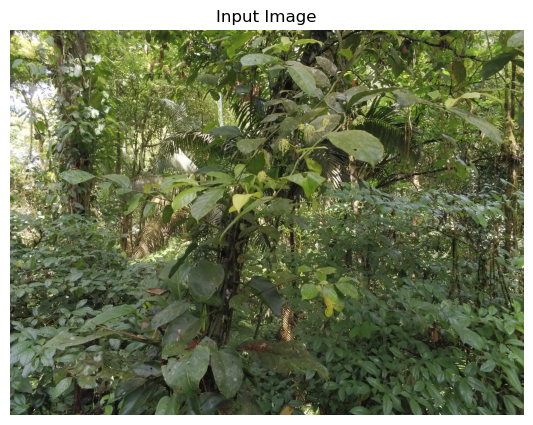

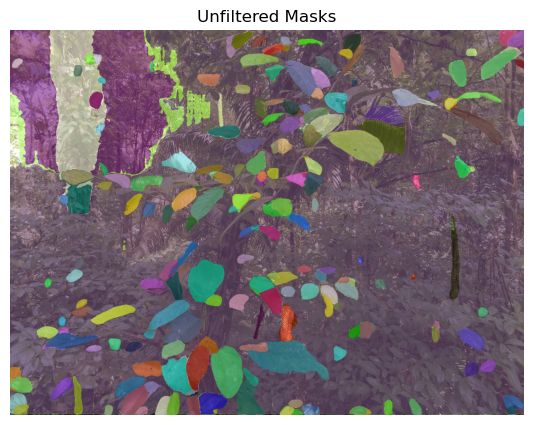

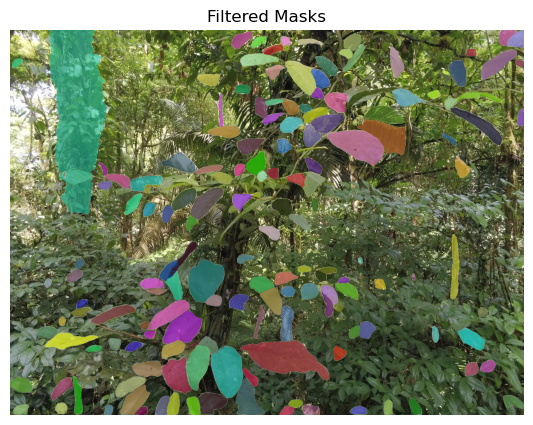

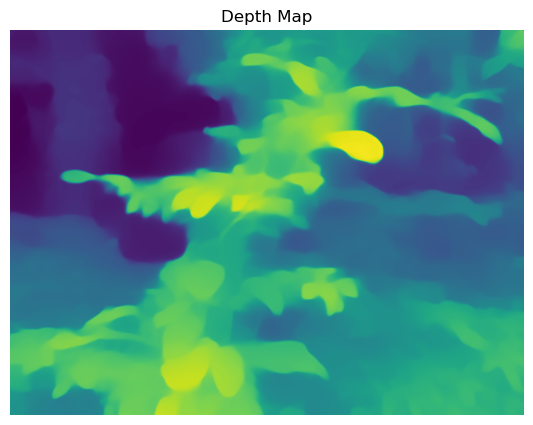

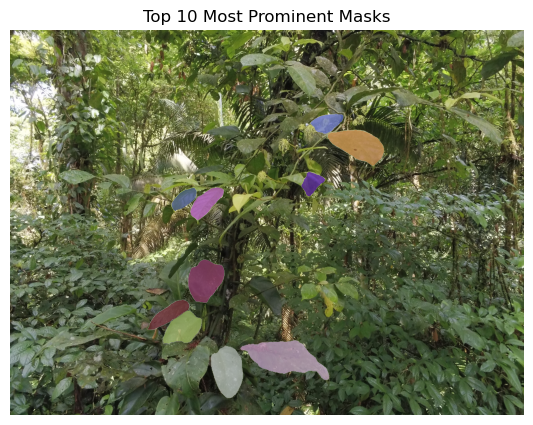

Using full_res_image for crops


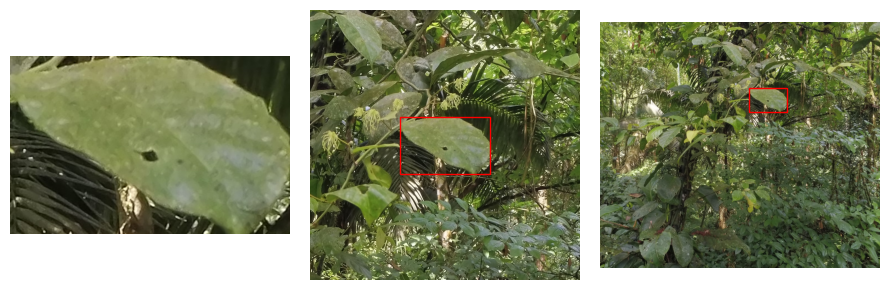

Using full_res_image for crops


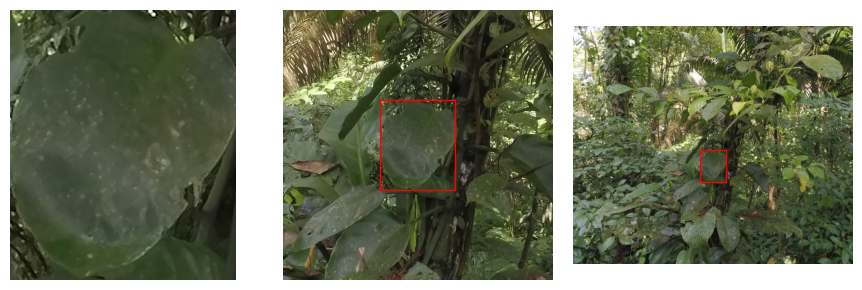

Using full_res_image for crops


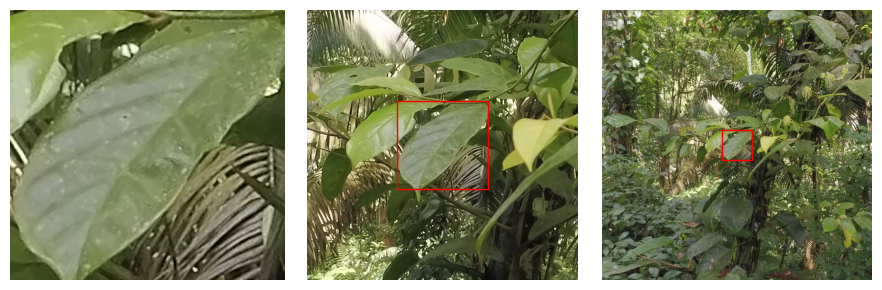

Using full_res_image for crops


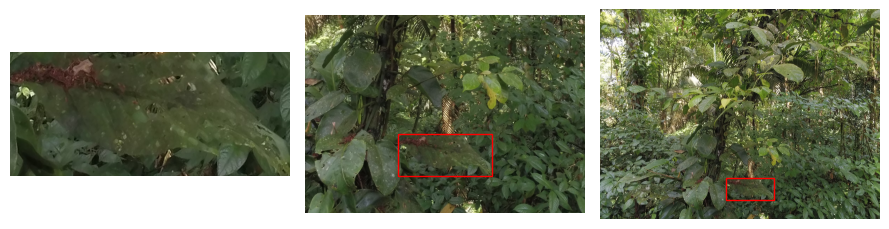

Using full_res_image for crops


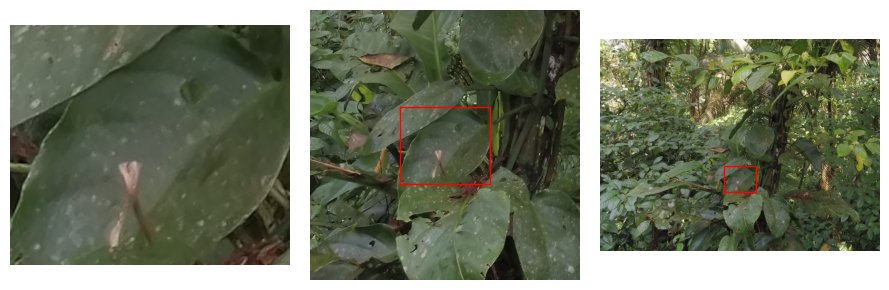

Using full_res_image for crops


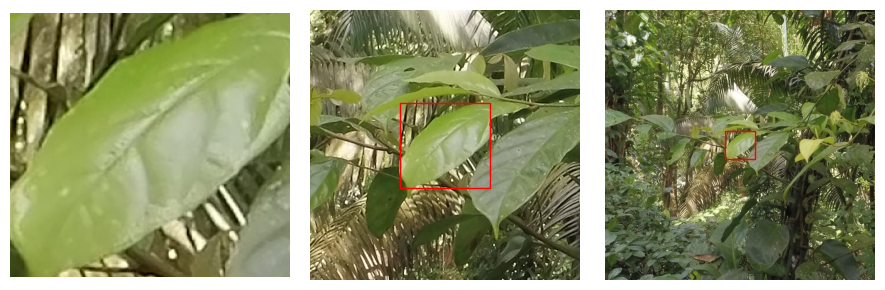

Using full_res_image for crops


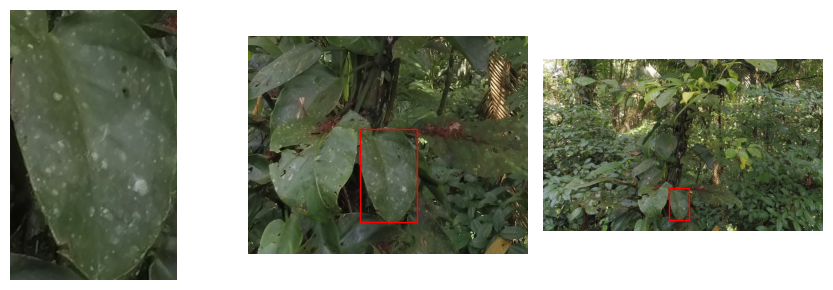

Using full_res_image for crops


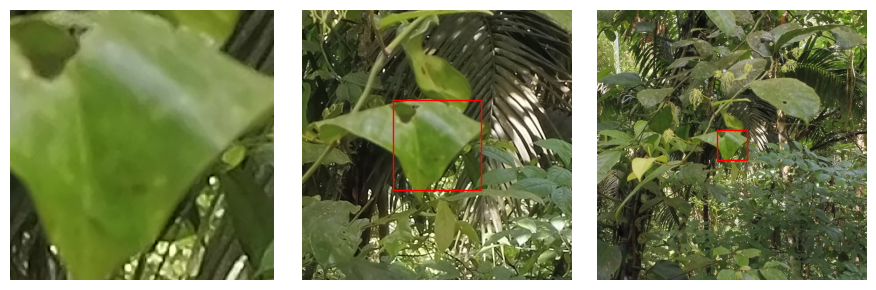

Using full_res_image for crops


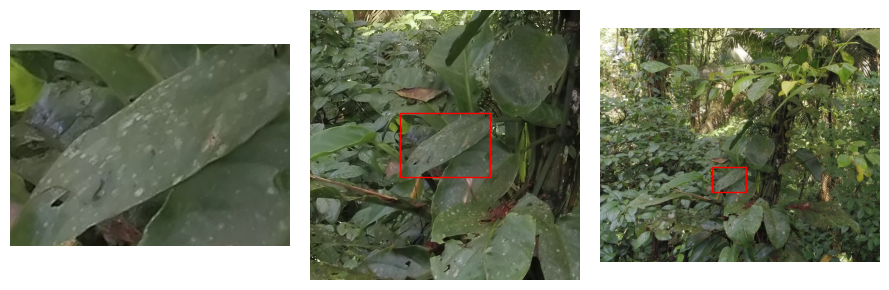

Using full_res_image for crops


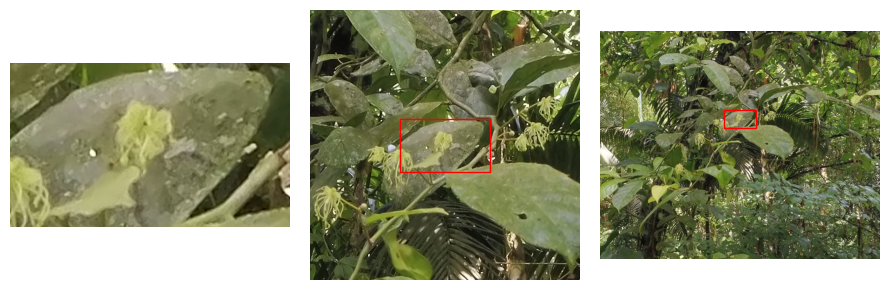

In [8]:
directory_path = R"G:\.shortcut-targets-by-id\1BCCfXZq98f4rFOF8m0AweybL4qQakAUB\Summer Dive 2022\Monteverde Imagery - Stephanie\River\Dry Flight\100MEDIA"
# image_basename = "P0870381.JPG"  # fern, shrub (close-up)
# image_basename = "P0950389.JPG"  # fern, shrub, star plant (close-up)
# image_basename = "P1070401.JPG"  # jungly
# image_basename = "P1360430.JPG"  # shrubs, colorful leaves
# image_basename = "P1420437.JPG"  # epiphyte and shrubs
image_basename = "P0800374.JPG"  # vine
# image_basename = "P1480443.JPG"  # fruit, and forest floor
# image_basename = "P1540449.JPG"  # stream surrounded by bushes
# image_basename = "P1550450.JPG"  # fungus on a log and a few plants

# directory_path = R"C:\Users\duker\Documents\id_from_image\durham_test_images"
# image_basename = "edge_canopy.png"
# image_basename = "looking_down.png"
# image_basename = "motion_blur.png"
# image_basename = "oak_tree.png"


image_path = os.path.join(directory_path, image_basename)
pdf_savepath = os.path.join("output", f"{os.path.splitext(image_basename)[0]}.pdf")
os.makedirs("output", exist_ok=True)

process_image(image_path, pdf_savepath)